#Basic example of how to train Resnet50 on CIFAR-100

###Download and import the libraries

In [ ]:
#make sure you have tensorflow installed
!pip install tensorflow

In [ ]:
#import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50

## Train a ResNet50 on the CIFAR100 dataset

In [ ]:
#import the dataset
cifar100 = tf.keras.datasets.cifar100
(X_train, Y_train), (X_test,Y_test) = cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
#create the validation set
x_train,x_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

In [ ]:
#use OneHotEncoding for the outputs
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)
y_test = to_categorical(Y_test, num_classes = 100)
x_train = x_train * 1.0/255
x_val = x_val * 1.0/255
X_test = X_test * 1.0/255
print(x_train.shape, x_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


In [ ]:
#do image augmentation
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(x_train)

In [ ]:
#if accuracy is not improving for 3 consecutive epochs then reduce the learning rate
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

In [ ]:
#import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
#change the final part so that it matches our dataset
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

In [ ]:
#set Stochastic Gradient Descent (SGD) as optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

In [ ]:
#compile and train
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 100,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 310s 847ms/step - accuracy: 0.0445 - loss: 4.7256 - val_accuracy: 0.0104 - val_loss: 10.1333 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 245s 783ms/step - accuracy: 0.2315 - loss: 3.2734 - val_accuracy: 0.0132 - val_loss: 6.5081 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 249s 794ms/step - accuracy: 0.3388 - loss: 2.7022 - val_accuracy: 0.2418 - val_loss: 3.1788 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 250s 796ms/step - accuracy: 0.4059 - loss: 2.3679 - val_accuracy: 0.4797 - val_loss: 2.0076 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 249s 795ms/step - accuracy: 0.4513 - loss: 2.1449 - val_accuracy: 0.5133 - val_loss: 1.8410 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 249s 795ms/step - accuracy: 0.4828 - loss: 1.9883 - val_accuracy: 0.5353 - val_loss: 1.7336 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 249s 795ms/step - accuracy: 

In [ ]:
#plot the training/validation loss and accuracy to check for overfitting
def plot_acc_loss(result):
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

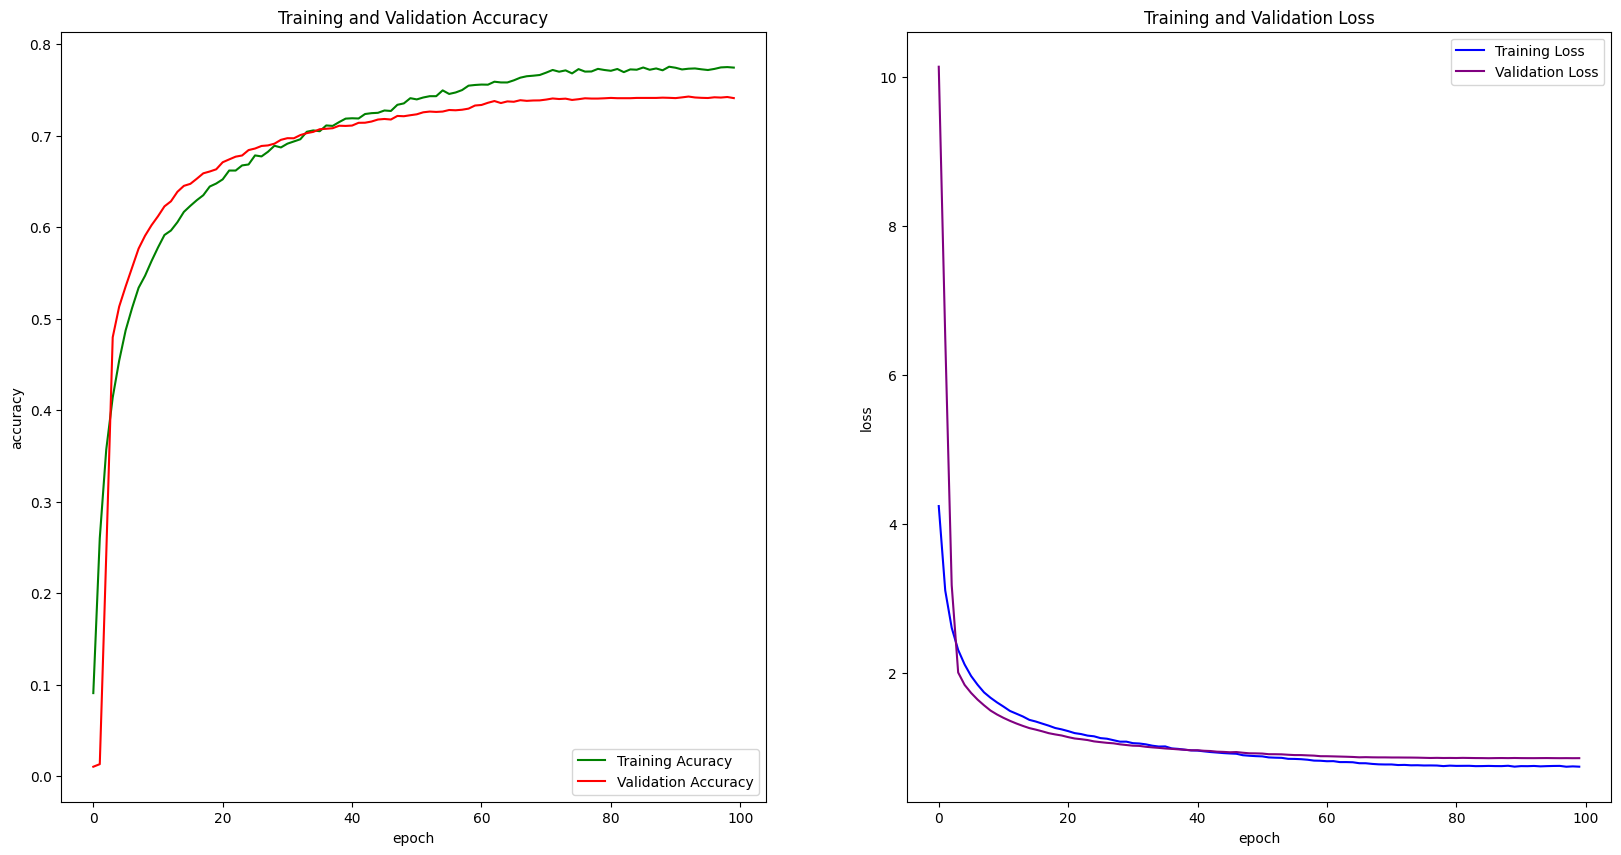

In [ ]:
plot_acc_loss(history)

In [ ]:
#save the model for later use
model.save('resnet50_on_cifar100.keras')